<a href="https://colab.research.google.com/github/engrodawood/Pytorch/blob/master/DL_Predictor2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [8]:
f=3
import numpy as np
bdir = f'/content/gdrive/My Drive/Pathology/Fold {f}'
Y = np.load(bdir+f'/Y_fold{f}.npy')


In [9]:
Y = Y.T
print(Y.shape)

(494, 6)


In [ ]:
X = np.load(bdir+'/X_fold2.npy')
print(X.shape)

(468, 256, 256, 3)


In [2]:
import torchvision
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(X[0].astype('uint8'))

NameError: ignored

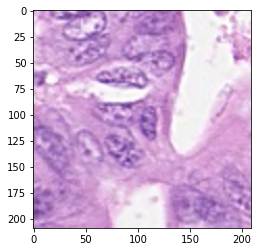

In [ ]:
plt.imshow(X[0][16:225,16:225].astype('uint8'))

In [ ]:
from skimage.transform import resize
resized = resize(X, (X.shape[0],224, 224,3))

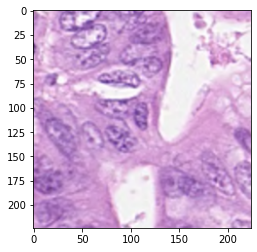

In [ ]:
plt.imshow(resized[0].astype('uint8'))

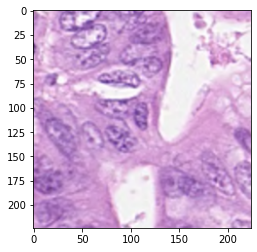

In [ ]:
plt.imshow(np.reshape(np.reshape(resized,(resized.shape[0],3,224,224)),(resized.shape[0],224,224,3))[0].astype('uint8'))

In [28]:
class FoldLoading(Dataset):
    """ Cancer dataset."""

    # Initialize your data, download, etc.
    def __init__(self,f=1):
        bdir = f'/content/gdrive/My Drive/Pathology/Fold {f}'
        X = np.load(bdir+f'/X_fold{f}.npy')
        X = resize(X, (X.shape[0],224, 224,3))
        X = np.reshape(X,(X.shape[0],3,224,224))
        X = X.astype('float32')
        self.X = torch.from_numpy(X)
        Y = np.load(bdir+f'/Y_fold{f}.npy').T
        #Y = np.reshape(Y,(Y.shape[0],1))
        self.Y = torch.from_numpy(Y).type(torch.FloatTensor)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index],self.Y[index]

    def __len__(self):
        return self.len

In [29]:
#switch device to gpu if available
from skimage.transform import resize

trainDataset = FoldLoading(f=3)
testDataset = FoldLoading(f=2)
#
train_loader = DataLoader(dataset=trainDataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1)
validation_loader = DataLoader(dataset=testDataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=1)

In [42]:
import torchvision.models as models
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
model = models.resnet18(pretrained = True)

In [43]:
# Freeze the parameters 
for param in model.parameters():
    param.requires_grad = False 

In [44]:
#Classifier architecture to put on top of resnet18
from collections import OrderedDict
fc = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(512,64)),
    ('relu', nn.ReLU()),
    ('Dropout',nn.Dropout()),
    ('fc2', nn.Linear(64,6))
]))

model.fc = fc

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.009)
batch_size=64

In [46]:
rmse_train_ep=[]
loss_train_ep=[]
loss_val_ep=[]
rmse_val_ep=[]    
def train(epoch):  
    model.train()  
    train_loss=0
    rmse_train=[]
    for batch_idx, (X,Y) in enumerate(train_loader):
        data,target = Variable(X).to(device), Variable(Y).to(device)
        optimizer.zero_grad()
        #import pdb; pdb.set_trace()
        output = model(data)
        loss = criterion(output, target)
        l=float(loss.data.cpu())
        train_loss+=l
        t_rmse=float(torch.sqrt(torch.mean((output-target)**2)).data.cpu())
        rmse_train.append(t_rmse)
        loss.backward()
        optimizer.step()
        if batch_idx % (batch_size-1) == 0:
            print('Train Epoch:',epoch,int(100 * batch_idx / len(train_loader)),'% ',' Loss', l,
                  'RMSE',t_rmse)
    rmse_train_ep.append(np.mean(np.array(rmse_train)))
    train_loss/=(len(train_loader.dataset)/batch_size)
    loss_train_ep.append(train_loss)
    print("Epoch : ",epoch,"Training Loss : ",train_loss, "  RMSE train ",rmse_train_ep[epoch-1])

def test(epoch):
  model.eval()
  val_loss = 0
  rmse_val=[]
  for batch_idx, (data,target) in enumerate(validation_loader):
      data,target = Variable(data), Variable(target)
      data = data.to(device)
      output = model(data)
      output=output.data.cpu()
      loss=float(criterion(output,target))
      val_loss+=loss
      rmse_val.append(float(torch.sqrt(torch.mean((output-target)**2)))) 
  val_loss/=(len(validation_loader.dataset)/batch_size)
  rmse_val_ep.append(np.mean(np.array(rmse_val)))
  loss_val_ep.append(val_loss)
  print('Epoch: ',epoch,'Val Loss',val_loss,'RMSE validation ',rmse_val_ep[epoch-1])

In [47]:
n_epoch=50           
for epoch in range(1, n_epoch):
    train(epoch)
    test(epoch)

Train Epoch: 1 0 %   Loss 154.13571166992188 RMSE 12.415140151977539
Epoch :  1 Training Loss :  115.94944608742409   RMSE train  10.45439100265503
Epoch:  1 Val Loss 147.58971333299945 RMSE validation  11.516572117805481
Train Epoch: 2 0 %   Loss 114.75575256347656 RMSE 10.712410926818848
Epoch :  2 Training Loss :  102.68474229820345   RMSE train  9.796274662017822
Epoch:  2 Val Loss 142.38889097556088 RMSE validation  11.269908905029297
Train Epoch: 3 0 %   Loss 148.035888671875 RMSE 12.166999816894531
Epoch :  3 Training Loss :  98.20198485339701   RMSE train  9.509277939796448
Epoch:  3 Val Loss 112.94514973958333 RMSE validation  10.039391160011292
Train Epoch: 4 0 %   Loss 67.94012451171875 RMSE 8.24258041381836
Epoch :  4 Training Loss :  88.95387570771129   RMSE train  9.186996519565582
Epoch:  4 Val Loss 114.78702903812767 RMSE validation  10.197706818580627
Train Epoch: 5 0 %   Loss 67.53787231445312 RMSE 8.21814250946045
Epoch :  5 Training Loss :  84.03582145907136   RMSE 

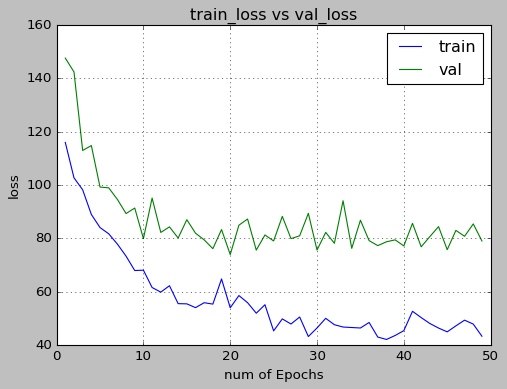

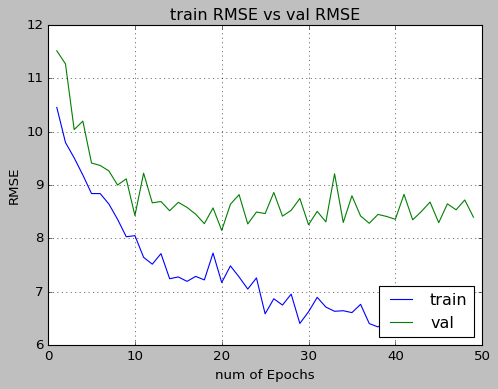

In [49]:
import matplotlib.pyplot as plt    
xc=range(1,n_epoch)
plt.figure(1,figsize=(7,5))
plt.plot(xc,np.array(loss_train_ep))
plt.plot(xc,np.array(loss_val_ep))
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])
plt.figure(2,figsize=(7,5))
plt.plot(xc,rmse_train_ep)
plt.plot(xc,rmse_val_ep)
plt.xlabel('num of Epochs')
plt.ylabel('RMSE')
plt.title('train RMSE vs val RMSE')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [50]:
model.eval()
f=2
bdir = f'/content/gdrive/My Drive/Pathology/Fold {f}'
X = np.load(bdir+f'/X_fold{f}.npy')
X = resize(X, (X.shape[0],224, 224,3))
X = np.reshape(X,(X.shape[0],3,224,224))
X = X.astype('float32')
X = torch.from_numpy(X)
target = np.load(bdir+f'/Y_fold{f}.npy').T

In [51]:
pred = model(X.to(device))
pred = np.array(pred.cpu().detach())
print(pred[0])
print(target[0])

[5.8877754  0.34285587 1.6503477  0.24382867 2.5944939  0.8298132 ]
[22.  1.  1.  0.  0.  1.]


Spearman correlation

In [52]:
import scipy
pred = pred.flatten()
target = target.flatten()
scipy.stats.spearmanr(pred,target)

SpearmanrResult(correlation=0.5149696214027717, pvalue=5.083672518248965e-190)

Correlation Plot

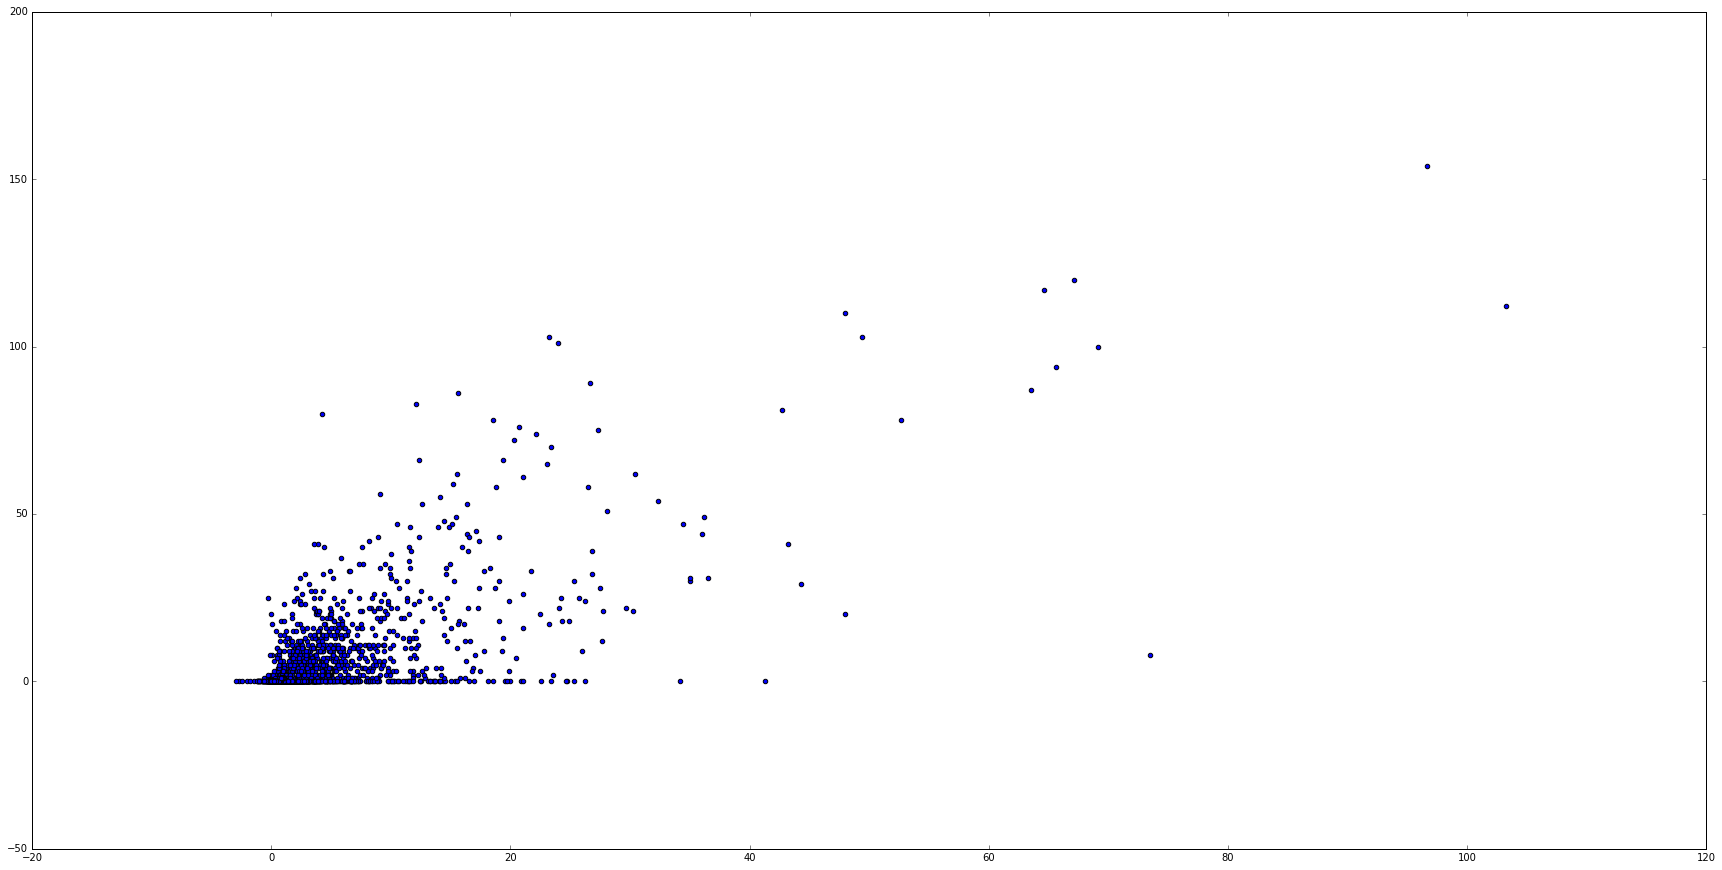

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))
plt.scatter(pred,target)